**14 September 2020**

# Lecture: Sentiment scoring

## Administrivia

* **Response post** due tomorrow (Tuesday) night by 9:00pm *if you want to respond to Wednesday's readings* (story "arcs," gendered words). 
  * Post responses to Canvas under the thread named "3. Sentiment scoring."
  * A reminder that at least one response is due no later than the evening of Tuesday, 9/22 (next week).
* **Problem set 1 (setup and basics)** grades and solution coming on Wednesday evening.
* **Problem set 2 (word counts)** due tomorrow by midnight.
* **Problem set 3 (sentiment)** will be on GitHub by Friday.
* **Slip days.** Five for the semester.
  * No slip days for response posts (only problem sets).
* TA **LeAnn McDowall** will hold office hours on Monday afternoons (2-3pm) and Thursday afternoons (4:30-5:30pm). These are in addition to mine and Maria's. See Canvas for Zoom link.
* Other questions or issues?

# What are we doing?

We want to determine the *sentiment* of a text and of the individual sentences from which the text is composed.

"Sentiment" can mean a lot of things:

* Positive and negative feelings
* Emotional intensity (could be good or bad)
* Amount or intensity of other emotions (joy, surprise, awe, fear, etc.)
* Maybe even "sentimentalness" (roughly, "nostalgia")

Today, we'll focus on sentiment as the expression of positive and negative feelings. This is the most common case in many text anlaysis problems.

## Supervised and unsupervised

There are two broad ways we could approach the task of senitment analysis:

* **Supervised** methods start with **labeled data** and try to learn the features that best predict the labels.
* **Unsupervised** methods start with **known-informative features** and produce labels or scores from those features.
* Advantages and disadvantages of each
  * In short: unfront labeling costs vs. later validation costs

We will work, for now, with **unsupervised** sentiment analysis. But there are lots of supervised approaches, too.

## Example case

* From Jockers' [*Syuzhet* vignette](https://cran.r-project.org/web/packages/syuzhet/vignettes/syuzhet-vignette.html). 
 * Note that this is an R package. We can't use it directly.
* "Syuzhet" = "plot" or "subject" in Russian; it refers to narrative order, rather than to the "true" order of the narrative's underlying events (which is called the "fabula").
* To see the difference, think about a flashback that occurs near the end of a story.

### Score some sentences ...

Polls!

1. **Basically this is a very silly test.**
1. **You are testing the Syuzhet package using short, inane sentences.**  
1. **I have finally finished writing this package.**  
1. **I won't have anything left to do.** 
1. **Honestly this use of the Fourier transformation is really quite elegant.**  

In [1]:
silly    = 0
inane    = 0
finished = 0
left     = 0
fourier  = 0

human_scores = [
    0,
    silly,
    inane,
    2,
    finished,
    -2,
    left,
    -2,
    -2,
    1,
    fourier,
    1.5
]

print("Overall human sentiment score:", sum(human_scores))

Overall human sentiment score: -1.5


### Ingest and tokenize the example "story"

Notice that our output data structure is a list of lists. The "outer" list contains sentences. The "inner" lists each contain the tokens in one sentence.

In [2]:
from nltk import sent_tokenize, word_tokenize

# The story. Why triple quotes?
story = '''\
  I begin this story with a neutral statement.  
  Basically this is a very silly test.  
  You are testing the Syuzhet package using short, inane sentences.  
  I am actually very happy today. 
  I have finally finished writing this package.  
  Tomorrow I will be very sad. 
  I won't have anything left to do. 
  I might get angry and decide to do something horrible.  
  I might destroy the entire package and start from scratch.  
  Then again, I might find it satisfying to have completed my first R package. 
  Honestly this use of the Fourier transformation is really quite elegant.  
  You might even say it's beautiful!'''

tokens = [word_tokenize(sent.lower()) for sent in sent_tokenize(story)]
print("Sentences:", len(tokens))
print("Total tokens:", sum([len(sent) for sent in tokens]))
print("\nSample sentences:", tokens[0:2])

Sentences: 12
Total tokens: 118

Sample sentences: [['i', 'begin', 'this', 'story', 'with', 'a', 'neutral', 'statement', '.'], ['basically', 'this', 'is', 'a', 'very', 'silly', 'test', '.']]


Quick aside: **list comprehension**:

* It's a compact way to write a for loop and store the result in a list.
* Good for quick stuff, but not flexible and not very legible.

```
tokens = [word_tokenize(sent.lower()) for sent in sent_tokenize(story)]
```

is the same as

```
tokens = []
for sent in sent_tokenize(story):
    tokens.append(word_tokenize(sent.lower()))
```

### Set up sentiment dictionaries

We want to compare a couple of them. Specifically, we'll use:

* NLTK's copy of Hu and Liu's lexicon ([paper](https://www.cs.uic.edu/~liub/publications/kdd04-revSummary.pdf) | [dataset](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html))
* Mohammad's [EmoLex](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm) from the Canadian National Research Council (NRC)

Are these good and suitable choices for our task? Let's (begin to) find out!

In [3]:
from collections import defaultdict
from nltk.corpus import opinion_lexicon
import os
import random

# NLTK simple lexicon (from Hu and Liu (2004))
nltk_lexicon = {
    'positive' : set(opinion_lexicon.positive()), # Why cast to a set?
    'negative' : set(opinion_lexicon.negative())
}
# Print a sample of the NLTK lexicon
print('NLTK lexicon sample')
for key in nltk_lexicon.keys():
    print(f'{key}:', random.sample(nltk_lexicon[key], 5))
    
# NRC lexicon (from Mohammad, http://sentiment.nrc.ca/lexicons-for-research/)
# No package for this, just read the data from a local file
emolex_file = os.path.join('..', 'data', 'lexicons', 'emolex.txt')
nrc_lexicon = defaultdict(dict) # Like Counter(), defaultdict eases dictionary creation
with open(emolex_file, 'r') as f:
    # emolex file format is: word emotion value
    for line in f:
        word, emotion, value = line.strip().split()
        nrc_lexicon[word][emotion] = int(value)
# Print a sample of the NRC lexicon
print('\nNRC lexicon sample')       
for key in random.sample(nrc_lexicon.keys(), 2):
    print(f'{key}:', nrc_lexicon[key])

NLTK lexicon sample
positive: ['superior', 'hale', 'clarity', 'astonished', 'attune']
negative: ['blameworthy', 'jealously', 'precarious', 'nonresponsive', 'malcontented']

NRC lexicon sample
interchanged: {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'negative': 0, 'positive': 0, 'sadness': 0, 'surprise': 0, 'trust': 0}
doom: {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 1, 'joy': 0, 'negative': 1, 'positive': 0, 'sadness': 0, 'surprise': 0, 'trust': 0}


### Define scoring function

Set up a function to score a word as positive of negative using either the NLTK or NRC dictionary.

In [4]:
def word_sentiment_score(word, method='nrc', lex=nrc_lexicon):
    '''
    Takes a word, optional method in ['nrc', 'nltk'], and optional lexicon dictionary.
    Returns 1 (if positive), -1 (if negative), 0 (neutral), or None (not in lex).
    '''
    word = word.lower() # Handle non-case-folded inputs
    if method.lower() == 'nrc':
        if word in lex: # Only score words that are in the lexicon
            pos = lex[word]['positive']
            neg = lex[word]['negative']
            if pos == neg: # Ties (mostly 0==0) return zero
                return 0
            elif pos > neg:
                return 1
            else:
                return -1
    elif method.lower() == 'nltk':
        if word in lex['positive']:
            return 1
        elif word in lex['negative']:
            return -1
    else:
        raise NameError("Method not in ['nrc', 'nltk']")
    return None # If word not in lexicon, return None (not zero). Why do this?

In [5]:
print("NRC  'analyst':", word_sentiment_score('analyst'))
print("NLTK 'analyst':", word_sentiment_score('analyst', method='nltk', lex=nltk_lexicon))

NRC  'analyst': 1
NLTK 'analyst': None


### Score our example sentences

For reference, here are our crowd-sourced scores:

In [6]:
# Human scores
print("Method: human")
print("Sentence scores:", human_scores)
print("Summary score:", sum(human_scores))

Method: human
Sentence scores: [0, 0, 0, 2, 0, -2, 0, -2, -2, 1, 0, 1.5]
Summary score: -1.5


In [7]:
# Calculate and compare dictionary scores

# Scoring methods for input
methods = {
    'nltk':nltk_lexicon,
    'nrc' :nrc_lexicon
}

# Calculate, record, and print scores
method_scores = {} # To store results
for method in methods:
    sentence_scores = [] # Could rewrite next few lines as a list comprehension
    for sent in tokens:
        sentence_score = 0
        for word in sent:
            word_score = word_sentiment_score(word, method=method, lex=methods[method])
            if word_score != None:
                sentence_score += word_score
        sentence_scores.append(sentence_score)
    method_scores[method] = sentence_scores # Save sentence-level scores
    # Print results
    print("Method:", method)
    print("Sentence scores:", sentence_scores)
    print("Summary score:", sum(sentence_scores),'\n')

Method: nltk
Sentence scores: [0, -1, -1, 1, 0, -1, 0, -2, -2, 1, 1, 1]
Summary score: -3 

Method: nrc
Sentence scores: [1, -1, -1, 1, 1, 0, 0, -2, 0, 0, 1, 1]
Summary score: 1 



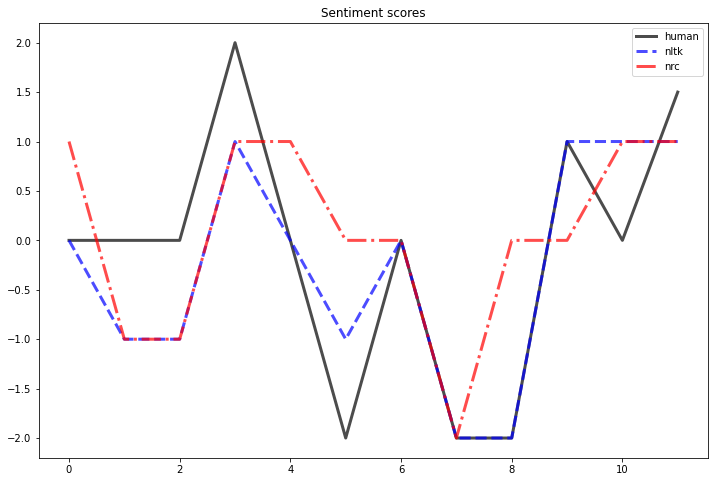

  I begin this story with a neutral statement.  
  Basically this is a very silly test.  
  You are testing the Syuzhet package using short, inane sentences.  
  I am actually very happy today. 
  I have finally finished writing this package.  
  Tomorrow I will be very sad. 
  I won't have anything left to do. 
  I might get angry and decide to do something horrible.  
  I might destroy the entire package and start from scratch.  
  Then again, I might find it satisfying to have completed my first R package. 
  Honestly this use of the Fourier transformation is really quite elegant.  
  You might even say it's beautiful!


In [8]:
# Visualize and print the story for discussion
import matplotlib.pyplot as plt

x = list(range(len(tokens)))
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(x, human_scores, '-',  c='black', label='human', alpha=0.7, linewidth=3)
plt.plot(x, method_scores['nltk'], '--', c='blue', label='nltk', alpha=0.7, linewidth=3)
plt.plot(x, method_scores['nrc'], '-.', c='red', label='nrc', alpha=0.7, linewidth=3)
plt.legend()
plt.title("Sentiment scores")
plt.show()

print(story)

### Discuss 

Do these scores make sense? 

* We can look at specific instances, like NRC on the first sentence (next code block)
* **Is this a happy story or not?**
 * Do the summary scores reflect our judgment about that?
 * If not, why not and how could we improve those scores?

In [9]:
# Token-level NRC scores for example sentence 1
for word in tokens[0]:
    print(word,word_sentiment_score(word))

i None
begin 0
this None
story 0
with None
a None
neutral 0
statement 1
. None


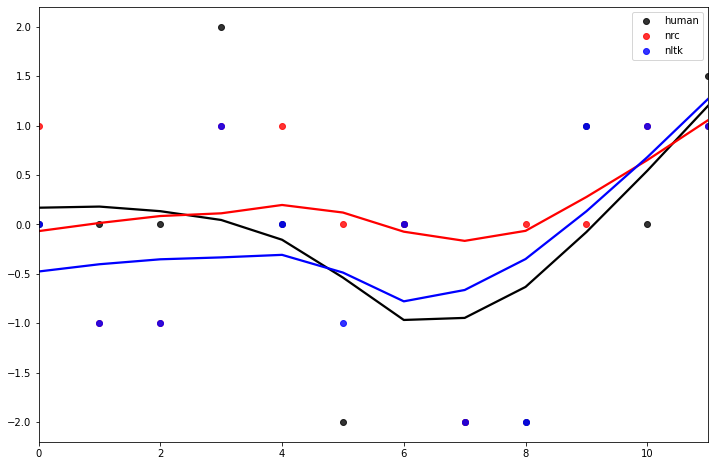

In [10]:
# Use Seaborn to plot data with lowess (local regression) fit
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,8))
sns.regplot(x, human_scores, lowess=True, color='k', label='human')
sns.regplot(x, method_scores['nrc'], lowess=True, color='r', label='nrc')
sns.regplot(x, method_scores['nltk'], lowess=True, color='b', label='nltk')
plt.legend()
plt.show()

## *Madame Bovary* (Flaubert, 1856/1857)

Expected arc: starts happy, ends sad.

Note that we do not lowercase our text (why not?), nor do we remove stopwords and punctuation (again, why not?).

In [11]:
# Read and tokenize the novel
bovary_file = os.path.join('..', 'data', 'texts', 'F-Flaubert-Madame_Bovary-1857-M.txt')
with open(bovary_file, 'r') as f:
    bovary_text = f.read()
bovary = [word_tokenize(sent) for sent in sent_tokenize(bovary_text)]
print("Sentences:", len(bovary))
print("Total tokens:", sum([len(sent) for sent in bovary]))

Sentences: 5695
Total tokens: 140026


Note one small change below: we divide sentence sentiment by sentence length, so that long sentences don't count more than short ones.

In [12]:
# Score it using NLTK and NRC methods
bovary_scores = {}
for method in methods:
    sentence_scores = []
    for sent in bovary:
        sentence_score = 0
        for word in sent:
            word_score = word_sentiment_score(word, method=method, lex=methods[method])
            if word_score != None:
                sentence_score += word_score
        sentence_scores.append(sentence_score/len(sent))
    bovary_scores[method] = sentence_scores
    print("Method:", method)
    print("Summary score:", round(sum(bovary_scores[method]),2),'\n')

Method: nltk
Summary score: -18.04 

Method: nrc
Summary score: 50.89 



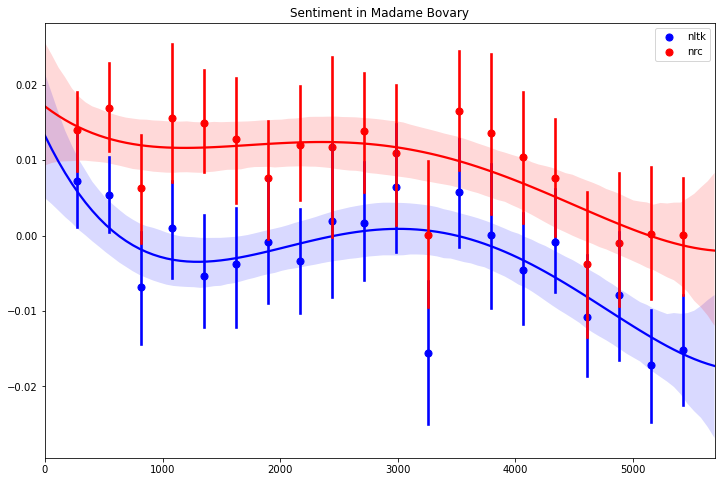

In [13]:
# Plot results with 4th-order polynomial fit (why?)
fig, ax = plt.subplots(figsize=(12,8))
x_bov = list(range(len(bovary)))
sns.regplot(x_bov, bovary_scores['nltk'], order=4, scatter=False, color='b', label=None)
sns.regplot(x_bov, bovary_scores['nltk'], x_bins=20, scatter=True, fit_reg=False, color='b', label='nltk')
sns.regplot(x_bov, bovary_scores['nrc'], order=4, scatter=False, color='r', label=None)
sns.regplot(x_bov, bovary_scores['nrc'], x_bins=20, scatter=True, fit_reg=False, color='r', label='nrc')
plt.title("Sentiment in Madame Bovary")
plt.legend()
plt.show()

**Discuss:** How would you compare and evaluate the results of these two methods on this text?

## Where to go from here

* More validation!
  * Is your lexicon good? For this kind of text? Written at this time?
* Other dictionaries
  * Develop your own?
  * See Jurafsky and Martin for clever and/or complex ideas
    * Example: tag adjectives. Those that appear on either side of the word *and* probably have the same sentiment polarity; those linked by *but* are likely opposites.
    * Lots of embedding-based approaches, too.
* Other aspects of sentiment/emotion/affect 
  * NRC 'anger', 'surprise', 'trust', etc.
* Other texts and other *types* of text
* **Combine sentiment with other kinds of text- and sentence-level scoring**
  * Gender, time period (linguistic drift, yikes!), translations of the same text, news coverage of candidates, ...
  * Problem set 3 will try this
* More ideas?